<a href="https://colab.research.google.com/github/Anuj040/Pedestrian-Detection/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup work environment

In [ ]:
!pip install -U tensorflow==2.4.1

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

##Object Detection Pipeline

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Import Object detection dependencies

In [ ]:
from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

## Label Mapping utility

In [ ]:
% cd /content
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Get Dataset

In [ ]:
  !git clone --depth 1 https://github.com/Anuj040/Pedestrian-Detection

In [ ]:
% cd /content/Pedestrian-Detection/
!python xml_to_csv.py

In [ ]:
!python generate_tfrecord.py --csv_input=images/train_labels.csv --image_dir=images/train --output_path=images/train.record
!python generate_tfrecord.py --csv_input=images/test_labels.csv --image_dir=images/test --output_path=images/test.record

In [ ]:
test_record_fname = '/content/Pedestrian-Detection/images/test.record'
train_record_fname = '/content/Pedestrian-Detection/images/train.record'
label_map_pbtxt_fname = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'

# Build and Load Pre-trained model

In [ ]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

In [ ]:
#You can change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'ssd_efficientdet_d0_512x512_coco17': {
        'model_name': 'ssd_efficientdet_d0_512x512_coco17_tpu-8',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_512x512_coco17_tpu-32.tar.gz',
        'batch_size': 8
    }
}
chosen_model = 'ssd_efficientdet_d0_512x512_coco17'
num_steps = 100 
num_eval_steps = 50 #Perform evaluation after so many steps
model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up the training

In [ ]:
#Download pretrained weights
%mkdir /content/deploy/
%cd /content/deploy/
import tarfile
download_tar = "http://download.tensorflow.org/models/object_detection/tf2/20200711/" + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()
#Shorten the folder name
os.rename('efficientdet_d0_coco17_tpu-32','efficientdet_d0')

In [ ]:
#Prepare loaded model for retraining
fine_tune_checkpoint = '/content/deploy/efficientdet_d0/checkpoint/ckpt-0'
pipeline_file = '/content/deploy/ssd_efficientdet_d0_512x512_coco17_tpu-8.config'
model_dir = '/content/training/'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)

In [ ]:
#Check if all configuration is OK:
print(fine_tune_checkpoint)
print(train_record_fname)
print(label_map_pbtxt_fname)
print(batch_size)
print(num_steps)
print(num_classes)
print(pipeline_file)
print(model_dir)

In [ ]:
%cd /content

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

## Model Saving

In [ ]:
#run conversion script to save the retrained model:
#Saved model will be in saved_model.pb file:

import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

## Import model for Inference

In [ ]:
from object_detection.builders import model_builder

#Recover our saved model with the latest checkpoint:
pipeline_config = pipeline_file
#Put the last ckpt from training in here, don't use long pathnames:
model_dir = '/content/training/ckpt-1'
model_dir = "/content/deploy/efficientdet_d0/checkpoint/ckpt-0"
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore last checkpoint
ckpt = tf.train.Checkpoint(
      model=detection_model)
#ckpt.restore(os.path.join(model_dir))
ckpt.restore(model_dir)

#Function perform detection of the object on image in tensor format: 
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  # @tf.function
  def detect_fn(image):
    """Detect objects in image."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn
  
#Define function which performs detection: 
detect_fn = get_model_detection_function(detection_model)


#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map_path = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

## Image Utilities

In [ ]:
#Utility functions for presenting the results:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.
  Args:
    path: the file path to the image
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]


In [ ]:
IMAGES_FOR_TEST = {
  'Beach' : '/content/models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

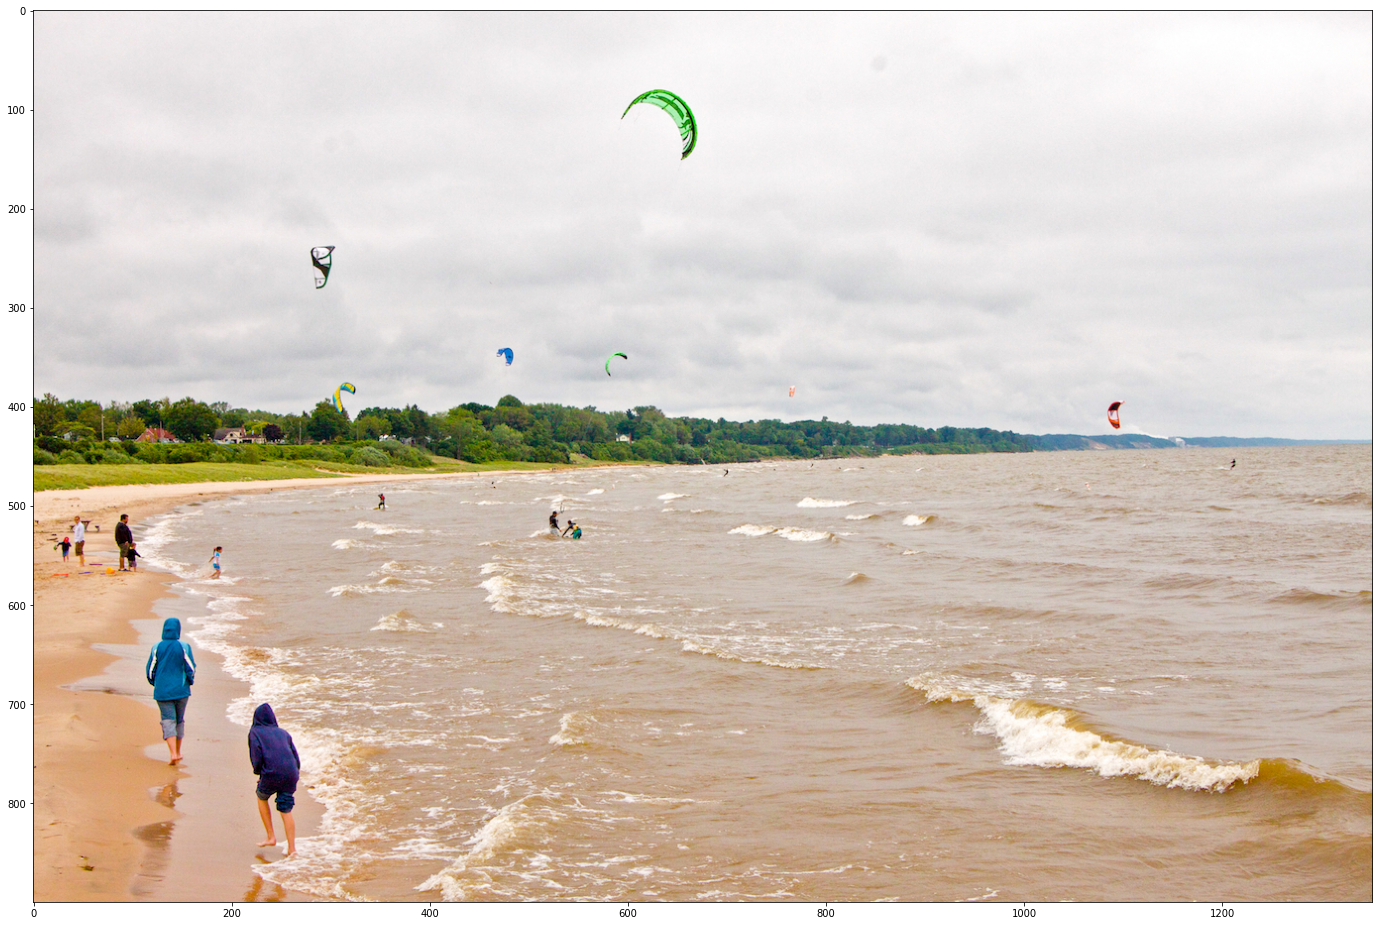

In [ ]:
selected_image = 'Beach' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## Inference

In [ ]:
#running inference
#Perform detection on the image in tensor format:
input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
result, predictions_dict, shapes = detect_fn(input_tensor)

ValueError: ignored

## Vizualise

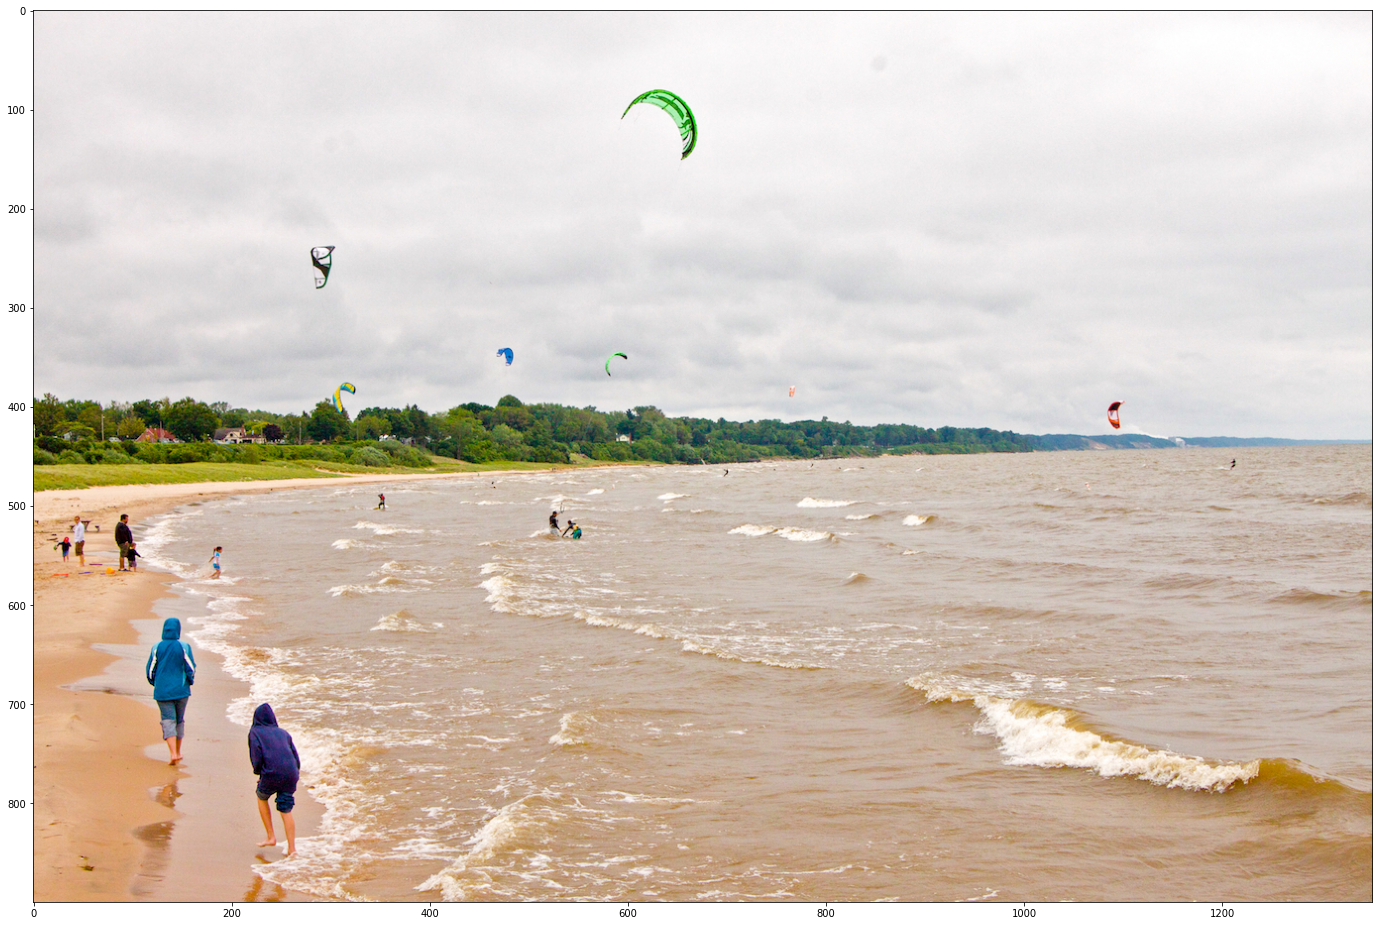

In [ ]:
label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0].numpy(),
      (result['detection_classes'][0].numpy() + label_id_offset).astype(int),
      result['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()